In [1]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
from IPython.display import Markdown, display

import awkward as ak

import networkx as nx
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from pylab import cm
import glob
import tqdm
import argparse
import os.path as osp


In [11]:
def plot_tracksters(ax, vx, vy, vz, ve):
    ax.set_xlabel("x (cm)")
    ax.set_ylabel("y (cm)")
    ax.set_zlabel("z (cm)")
    if ve is None:
        ve = np.ones(len(vx))*10
    for i, x, y, z, e in zip(range(len(vx)), vx, vy, vz, ve):
        plot_trackster(ax, i, x, y, z, e)
def get_event_window(ex, ey, ez, ee, zoom=1, e_threshold=2):

    ef = np.where(ak.flatten(ee) > e_threshold)

    x_max = max(ak.flatten(ex)[ef])
    x_min = min(ak.flatten(ex)[ef])
    y_max = max(ak.flatten(ey)[ef])
    y_min = min(ak.flatten(ey)[ef])
    z_max = max(ak.flatten(ez)[ef])
    z_min = min(ak.flatten(ez)[ef])

    x_zoom = (x_max - x_min) / zoom
    x_max -= x_zoom
    x_min += x_zoom

    y_zoom = (y_max - y_min) / zoom
    y_max -= y_zoom
    y_min += y_zoom

    z_zoom = (z_max - z_min) / zoom
    z_max -= z_zoom
    z_min += z_zoom

    return (x_min, x_max), (y_min, y_max), (z_min, z_max)

In [2]:
filename = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/wredjeb/TICLv4Sample/CMSSW_13_X/GNNTraining/CloseByPion0PU/ntuples_10_600/new_ntuples_15643818_42.root"
file = uproot.open(filename)
tracks = file["ticlNtuplizer/tracks"]
tracksters = file["ticlNtuplizer/tracksters"]
simtracksters = file["ticlNtuplizer/simtrackstersSC"]
simtrackstersCP = file["ticlNtuplizer/simtrackstersCP"]
ass = file["ticlNtuplizer/associations"]
gra = file["ticlNtuplizer/graph"]
cand = file["ticlNtuplizer/candidates"]
lc = file["ticlNtuplizer/clusters"]


In [4]:
def check_point_cone(h,angle,start_point,x,y,z,eigenvector):
    test_point = np.array([x,y,z])
    base_radius = np.tan(angle)*h
    cone_dist = np.dot(test_point-start_point,eigenvector)
    cone_r = (cone_dist/h)*base_radius
    dist = np.linalg.norm((test_point-start_point)-cone_dist*eigenvector)
    return dist<cone_r

def connected_components(pairs):
    components = []

    for a, b in pairs:
        for component in components:
            if a in component:
                for i, other_component in enumerate(components):
                    if b in other_component and other_component != component: 
                        component.extend(other_component)
                        components[i:i+1] = []
                        break 
                else: 
                    if b not in component:
                        component.append(b)
                break 
            if b in component: 
                component.append(a)
                break 
        else: 
#             if components:
#                 if a or b in component:
#                     break
#             else:
            components.append([a, b])
        
       
    return components
def flatten_array(arr):
    flattened = []
    for item in arr:
        if isinstance(item, list):
            flattened.extend(flatten_array(item))
        else:
            flattened.append(item)
    return flattened
def order_pairs(pairs):
    sorted_pairs = sorted(pairs, key=lambda pair: (pair[1], pair[0]))
    return sorted_pairs

In [6]:
trk_data = tracksters.arrays(["NTracksters", "raw_energy","raw_em_energy","barycenter_x","barycenter_y",
                              "barycenter_z","eVector0_x", "eVector0_y","eVector0_z","EV1","EV2","EV3",
                              "vertices_indexes", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3", "vertices_x", "vertices_y",
                              "vertices_z", "vertices_energy", "layer_cluster_seed","trackster_barycenter_eta","trackster_barycenter_phi","raw_pt","NClusters"])
gra_data = gra.arrays(["linked_inners", "linked_outers"])
# ass_data = ass.arrays(["tsCLUE3D_recoToSim_SC", "tsCLUE3D_recoToSim_SC_score",
#                       "tsCLUE3D_simToReco_SC", "tsCLUE3D_simToReco_SC_score",
#                        "tsCLUE3D_simToReco_SC_sharedE", "tsCLUE3D_recoToSim_SC_sharedE"])

ass_data = ass.arrays([#'tsCLUE3D_recoToSim_PU', 'tsCLUE3D_recoToSim_PU_score', 'tsCLUE3D_recoToSim_PU_sharedE',
                                                      'tsCLUE3D_recoToSim_SC', 'tsCLUE3D_recoToSim_SC_score', 'tsCLUE3D_recoToSim_SC_sharedE', 'tsCLUE3D_simToReco_SC', 'tsCLUE3D_simToReco_SC_score', 
                                                      'tsCLUE3D_simToReco_SC_sharedE', 'tsCLUE3D_recoToSim_CP', 'tsCLUE3D_recoToSim_CP_score', 'tsCLUE3D_recoToSim_CP_sharedE', 'tsCLUE3D_simToReco_CP',
                                                      'tsCLUE3D_simToReco_CP_score', 'tsCLUE3D_simToReco_CP_sharedE',#'Mergetracksters_recoToSim_PU', #'Mergetracksters_recoToSim_PU_score'
#                                                           'Mergetracksters_recoToSim_PU_sharedE', 'Mergetracksters_simToReco_PU', 'Mergetracksters_simToReco_PU_score', 'Mergetracksters_simToReco_PU_sharedE', 
                                                      'Mergetracksters_recoToSim_CP','Mergetracksters_recoToSim_CP_score','Mergetracksters_simToReco_CP', 'Mergetracksters_simToReco_CP_sharedE', 
                                                      'Mergetracksters_simToReco_CP_score'])

cand_data = cand.arrays(["tracksters_in_candidate"])
lc_data = lc.arrays(['position_x', 'position_y', 'position_z', 'energy'])
try:
    simtrackstersSC_data = simtracksters.arrays(["stsSC_raw_energy", 'stsSC_boundaryPx', 'stsSC_boundaryPy', 'stsSC_boundaryPz'])
    simtrackstersCP_data = simtrackstersCP.arrays(["stsCP_raw_energy", 'stsCP_boundaryPx', 'stsCP_boundaryPy', 'stsCP_boundaryPz',"trackster_barycenter_eta","trackster_barycenter_phi","raw_pt"])
    
except Exception:
    simtrackstersSC_data = simtracksters.arrays(["raw_energy", 'boundaryPx', 'boundaryPy', 'boundaryPz','barycenter_x','NTracksters'])
    simtrackstersCP_data = simtrackstersCP.arrays(["raw_energy", 'boundaryPx', 'boundaryPy', 'boundaryPz','barycenter_x','NTracksters',"trackster_barycenter_eta","trackster_barycenter_phi","raw_pt"])

In [95]:
def plot_ticl_graph(trk_data,eid = 4):
    
    fig = plt.figure(figsize=(10, 20))
    ax2 = fig.add_subplot(131, projection='3d')
    ax3 = fig.add_subplot(132, projection = '3d')
    ax1 = fig.add_subplot(133, projection='3d')


    ax1.set_xlabel("x (cm)")
    ax1.set_ylabel("y (cm)")
    ax2.set_xlabel("x (cm)")
    ax2.set_ylabel("y (cm)")
    ax3.set_xlabel("x (cm)")
    ax3.set_ylabel("y (cm)")
    ax1.set_zlabel("z (cm)")
    ax2.set_zlabel("z (cm)")
    ax3.set_zlabel("z (cm)")

    # plt.axis('off')
    trk_xb = trk_data["barycenter_x"][eid]
    trk_yb = trk_data["barycenter_y"][eid]
    trk_zb = trk_data["barycenter_z"][eid]
    trk_e = trk_data["raw_energy"][eid]
    trk_x = trk_data.vertices_x[eid]
    trk_y = trk_data.vertices_y[eid]
    trk_z = trk_data.vertices_z[eid]
    trk_vi = trk_data["vertices_indexes"][eid]
    ex = trk_data["eVector0_x"][eid]
    ey = trk_data["eVector0_y"][eid]
    ez= trk_data["eVector0_z"][eid]
    evx = trk_data["EV1"][eid]
    evy = trk_data["EV2"][eid]
    evz = trk_data["EV3"][eid]
    percent = 0.
    angle = .33
    trk_r = np.sqrt(trk_data["barycenter_x"][eid]**2+trk_data["barycenter_y"][eid]**2+trk_data["barycenter_z"][eid]**2)
    max_r = np.max(trk_r)

    points = []
    edges = []
    for vi_m,(x, y, z, e,eigenvector1,eigenvector2,eigenvector3,vi) in enumerate(zip(trk_xb, trk_yb, trk_zb, trk_e,ex,ey,ez,trk_vi)):
       #height for cone visualization
        h = 20
        #create vertex point 
        start_point = np.array([x,y,z])
        #define direction of trackster barycenter and normalize
        eigenvector = np.array([eigenvector1,eigenvector2,eigenvector3])
        eigenvector /=np.linalg.norm(eigenvector)
        #create arbitrary vector not in same direction as eigenvector in order to create orthogonal vector
        not_ev = np.array([1,0,0])
        if (eigenvector ==not_ev).all():
            not_ev = np.array([0,1,0])
        #create orthogonal vector 1
        ev_cross = np.cross(eigenvector,not_ev)
        #create orthogonal vector 2
        ev_cross/=np.linalg.norm(ev_cross)
        ev_cross2 = np.cross(eigenvector,ev_cross)
        #ev_cross2/=np.linalg.norm(ev_cross)
        #cone_dist = np.dot(test_point-start_point,eigenvector)

        #surface ranges over t from 0 to length of axis and 0 to 2*pi

        t = np.linspace(0, h, 100)
        theta = np.linspace(0, 2 * np.pi, 100)
        #use meshgrid to make 2d arrays, generate cone central axis and opening
        line_points = [start_point + t * eigenvector for t in t]
        base_radius = np.tan(angle)*(np.linalg.norm(line_points[-1]-start_point))

        line_points = np.array(line_points)
        cone_dist = np.dot(line_points-start_point,eigenvector)
        R = (cone_dist/h)*base_radius
        t, theta = np.meshgrid(t, theta)
        #search through all tracksters, creating an edge if it exists within cone of main tracksters
        data = [[l,x,y,z,j] for l,(x,y,z,j) in enumerate(zip(trk_xb, trk_yb, trk_zb,trk_vi))]
        ordered_data = sorted(data, key=lambda a: -a[2])
        for j in gra_data[eid].linked_inners[vi_m]:
            xp = trk_xb[j]
            yp = trk_yb[j]
            zp = trk_zb[j]
            #print(xp)
            #print(gra_data.linked_inners[vi_m])
            edges.append([j,vi_m])
            edges.append([vi_m,j])
            ax1.plot([xp, x], [yp, y], [zp, z], c='grey', alpha=0.2)
            ax2.plot([xp, x], [yp, y], [zp, z], c='grey', alpha=0.2)
            ax3. plot([xp, x], [yp, y], [zp, z], c='grey', alpha=0.2)

        #generate coordinates for surface
        X, Y, Z = [start_point[i] + eigenvector[i] * t + R* np.sin(theta) * ev_cross[i] + R* np.cos(theta) * ev_cross2[i] for i in [0, 1, 2]]
       # ax1.plot_surface(X, Y, Z,alpha=.3)
        ax1.scatter(x, y, z, s=20*e)
        #ax2.plot_surface(X, Y, Z,alpha=1)
        ax2.scatter(x, y, z, s=20*e)
        ax3.scatter(x, y, z, s=20*e)

    clusters_x = lc["position_x"].array()
    clusters_y = lc["position_y"].array()
    clusters_z = lc["position_z"].array()
    clusters_e = lc["energy"].array()
    vi = trk_data.vertices_indexes[eid]
    # vi = simtracksters["stsSC_vertices_indexes"].array()[0:eid]

    # only take one endcap
    vz = ak.Array([clusters_z[eid][indices] for indices in vi])
    # tdx = vz > 0

    vx = ak.Array([clusters_x[eid][indices] for indices in vi])
    vy = ak.Array([clusters_y[eid][indices] for indices in vi])
    ve = ak.Array([clusters_e[eid][indices] for indices in vi])

    vzm = vz

    # xlim, ylim, zlim = get_event_window(vx, vy, vzm, ve)
    # ax1.set_xlim(xlim)
    # ax1.set_ylim(ylim)
    # ax1.set_zlim(zlim)
    #ax1.set_title(f"Top view: Trackster cones from PCA axis ({angle}) radians")
    ax1.view_init(0,0)
    #ax2.set_title(f"Front view: Trackstr cones from PCA axis ({angle}) radians")
    ax2.view_init(0, -90)
    ax3.view_init(90,0)
    fig.subplots_adjust(left=.01, right=3, bottom=0.1, top=0.9, wspace=.01)
    fig.suptitle("Cylinder Graph Visualizations")


    plt.show()


In [102]:

eid = 4
def plot_cone_graph(trk_data,angle= .1,eid = 4):
    fig = plt.figure(figsize=(10, 10))
    ax2 = fig.add_subplot(131, projection='3d')
    ax3 = fig.add_subplot(132, projection = '3d')
    ax1 = fig.add_subplot(133, projection='3d')


    ax1.set_xlabel("x (cm)")
    ax1.set_ylabel("y (cm)")
    ax2.set_xlabel("x (cm)")
    ax2.set_ylabel("y (cm)")
    ax3.set_xlabel("x (cm)")
    ax3.set_ylabel("y (cm)")
    ax1.set_zlabel("z (cm)")
    ax2.set_zlabel("z (cm)")
    ax3.set_zlabel("z (cm)")

    # plt.axis('off')
    trk_xb = trk_data["barycenter_x"][eid]
    trk_yb = trk_data["barycenter_y"][eid]
    trk_zb = trk_data["barycenter_z"][eid]
    trk_e = trk_data["raw_energy"][eid]
    trk_x = trk_data.vertices_x[eid]
    trk_y = trk_data.vertices_y[eid]
    trk_z = trk_data.vertices_z[eid]
    trk_vi = trk_data["vertices_indexes"][eid]
    ex = trk_data["eVector0_x"][eid]
    ey = trk_data["eVector0_y"][eid]
    ez= trk_data["eVector0_z"][eid]
    evx = trk_data["EV1"][eid]
    evy = trk_data["EV2"][eid]
    evz = trk_data["EV3"][eid]
    percent = 0.
    angle = angle
    trk_r = np.sqrt(trk_data["barycenter_x"][eid]**2+trk_data["barycenter_y"][eid]**2+trk_data["barycenter_z"][eid]**2)
    max_r = np.max(trk_r)

    points = []
    edges = []
    for vi_m,(x, y, z, e,eigenvector1,eigenvector2,eigenvector3,vi) in enumerate(zip(trk_xb, trk_yb, trk_zb, trk_e,ex,ey,ez,trk_vi)):
       #height for cone visualization
        h = 20
        #create vertex point 
        start_point = np.array([x,y,z])
        #define direction of trackster barycenter and normalize
        eigenvector = np.array([eigenvector1,eigenvector2,eigenvector3])
        eigenvector /=np.linalg.norm(eigenvector)
        #create arbitrary vector not in same direction as eigenvector in order to create orthogonal vector
        not_ev = np.array([1,0,0])
        if (eigenvector ==not_ev).all():
            not_ev = np.array([0,1,0])
        #create orthogonal vector 1
        ev_cross = np.cross(eigenvector,not_ev)
        #create orthogonal vector 2
        ev_cross/=np.linalg.norm(ev_cross)
        ev_cross2 = np.cross(eigenvector,ev_cross)
        #ev_cross2/=np.linalg.norm(ev_cross)
        #cone_dist = np.dot(test_point-start_point,eigenvector)

        #surface ranges over t from 0 to length of axis and 0 to 2*pi

        t = np.linspace(0, h, 100)
        theta = np.linspace(0, 2 * np.pi, 100)
        #use meshgrid to make 2d arrays, generate cone central axis and opening
        line_points = [start_point + t * eigenvector for t in t]
        base_radius = np.tan(angle)*(np.linalg.norm(line_points[-1]-start_point))

        line_points = np.array(line_points)
        cone_dist = np.dot(line_points-start_point,eigenvector)
        R = (cone_dist/h)*base_radius
        t, theta = np.meshgrid(t, theta)
        #search through all tracksters, creating an edge if it exists within cone of main tracksters
        data = [[l,x,y,z,j] for l,(x,y,z,j) in enumerate(zip(trk_xb, trk_yb, trk_zb,trk_vi))]
        ordered_data = sorted(data, key=lambda a: -a[2])
        for vi_n,xp, yp, zp, j in ordered_data:
            if check_point_cone(h,angle,start_point,xp,yp,zp,eigenvector):
                edges.append([vi_m,vi_n])
                ax1.plot([xp, x], [yp, y], [zp, z], c='grey', alpha=0.2)
                ax2.plot([xp, x], [yp, y], [zp, z], c='grey', alpha=0.2)
                ax3. plot([xp, x], [yp, y], [zp, z], c='grey', alpha=0.2)

        #generate coordinates for surface
        X, Y, Z = [start_point[i] + eigenvector[i] * t + R* np.sin(theta) * ev_cross[i] + R* np.cos(theta) * ev_cross2[i] for i in [0, 1, 2]]
        #ax1.plot_surface(X, Y, Z,alpha=.3)
        ax1.scatter(x, y, z, s=20*e)
        #ax2.plot_surface(X, Y, Z,alpha=1)
        ax2.scatter(x, y, z, s=20*e)
        ax3.scatter(x, y, z, s=20*e)
        #ax2.plot_surface(X, Y, Z,alpha=1)
       # ax2.scatter(x, y, z, s=20*e)

    clusters_x = lc["position_x"].array()
    clusters_y = lc["position_y"].array()
    clusters_z = lc["position_z"].array()
    clusters_e = lc["energy"].array()
    vi = trk_data.vertices_indexes[eid]
    # vi = simtracksters["stsSC_vertices_indexes"].array()[0:eid]

    # only take one endcap
    vz = ak.Array([clusters_z[eid][indices] for indices in vi])
    # tdx = vz > 0

    vx = ak.Array([clusters_x[eid][indices] for indices in vi])
    vy = ak.Array([clusters_y[eid][indices] for indices in vi])
    ve = ak.Array([clusters_e[eid][indices] for indices in vi])

    vzm = vz

    # xlim, ylim, zlim = get_event_window(vx, vy, vzm, ve)
    # ax1.set_xlim(xlim)
    # ax1.set_ylim(ylim)
    # ax1.set_zlim(zlim)
    ax1.view_init(0,0)
    #ax2.set_title(f"Front view: Trackstr cones from PCA axis ({angle}) radians")
    ax2.view_init(0, -90)
    ax3.view_init(90,0)
    fig.subplots_adjust(left=.01, right=3, bottom=0.1, top=0.9, wspace=.01)
    fig.suptitle("Cone Graph Visualizations")
    plt.show()
    # ax1.get_yaxis().set_ticks([])
    # ax1.get_yaxis().set_visible(False)

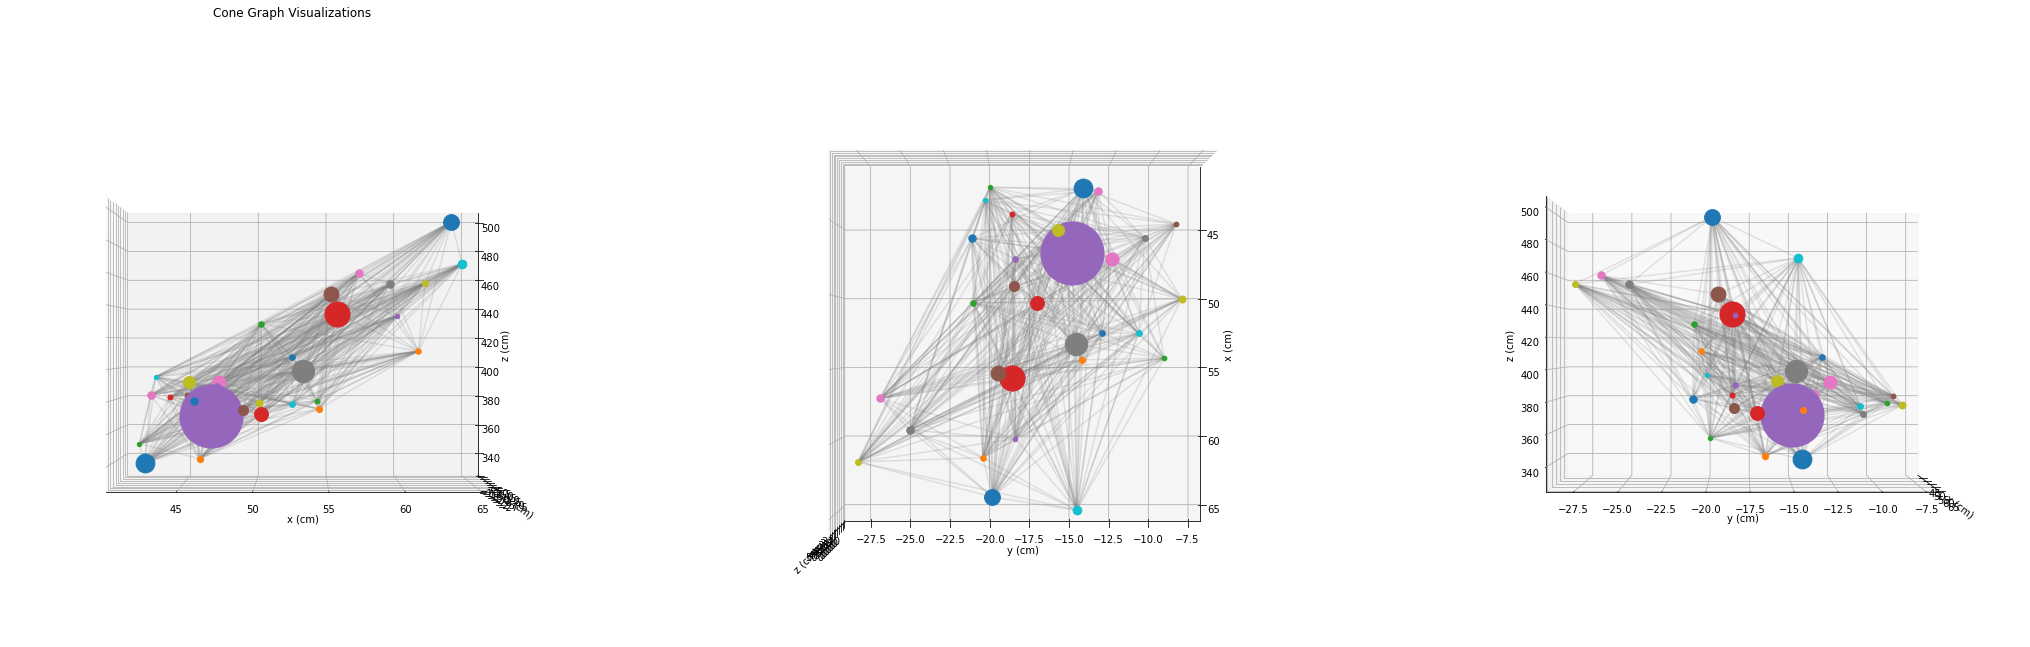

In [104]:
plot_cone_graph(trk_data,angle= .8,eid = 4)

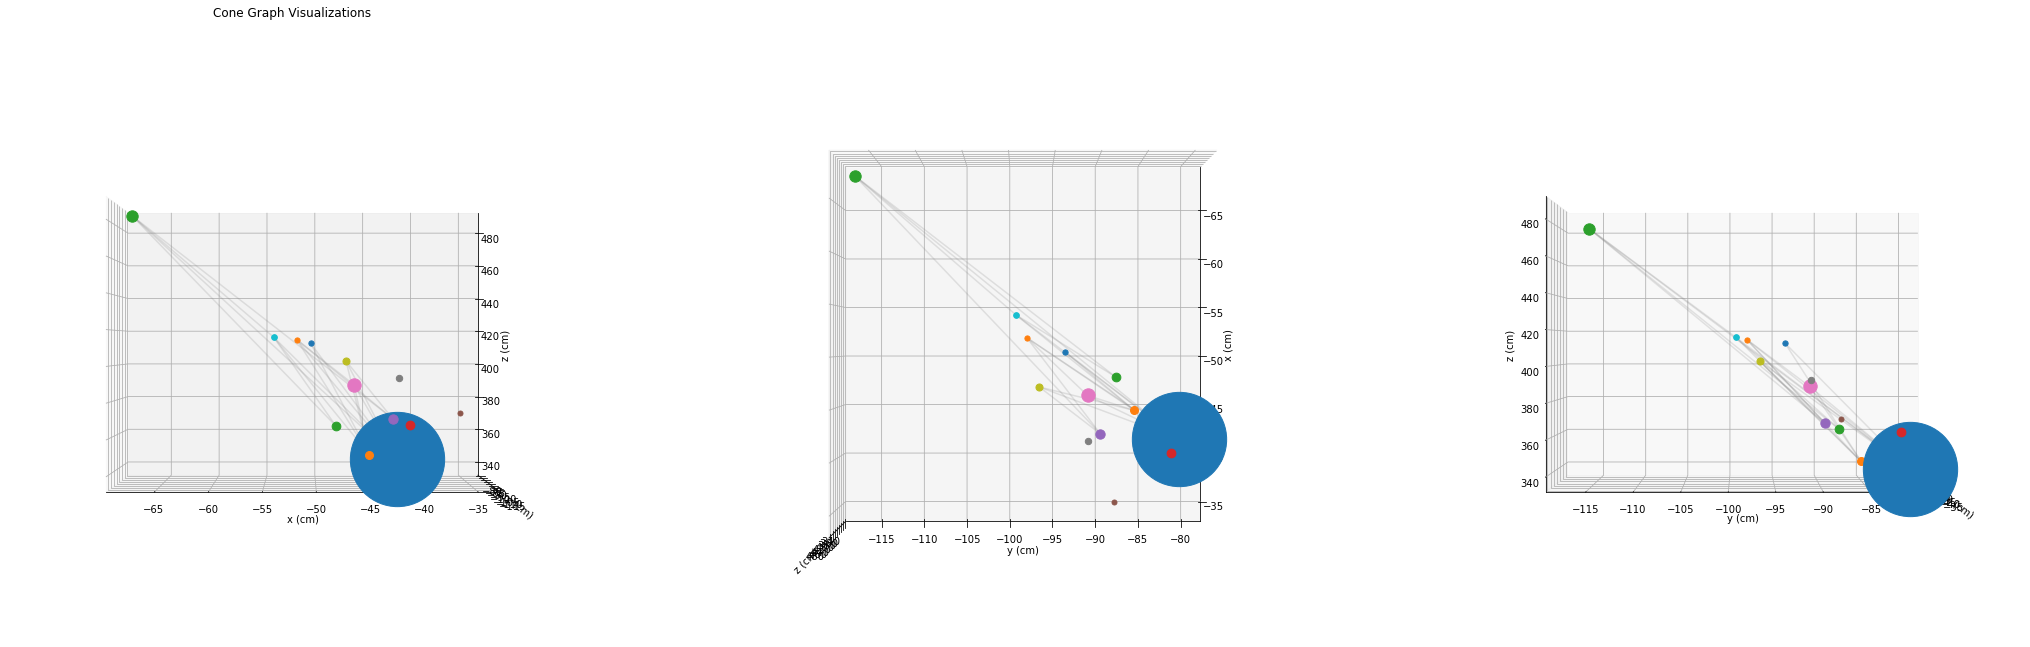

In [84]:
plot_cone_graph(trk_data,angle= .1,eid = 1)

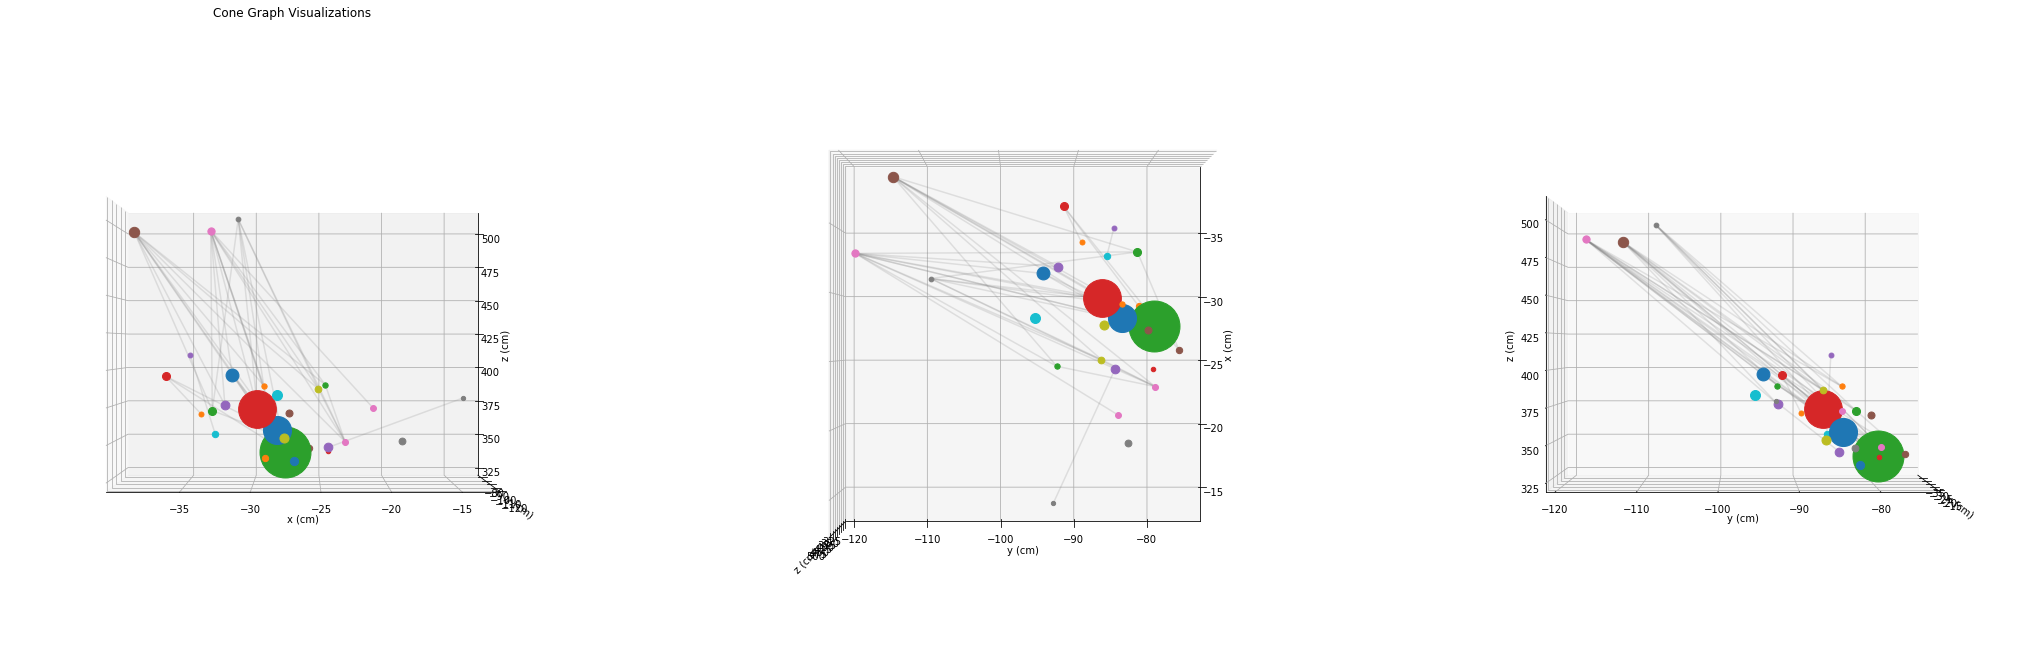

In [85]:
plot_cone_graph(trk_data,angle= .1,eid = 2)

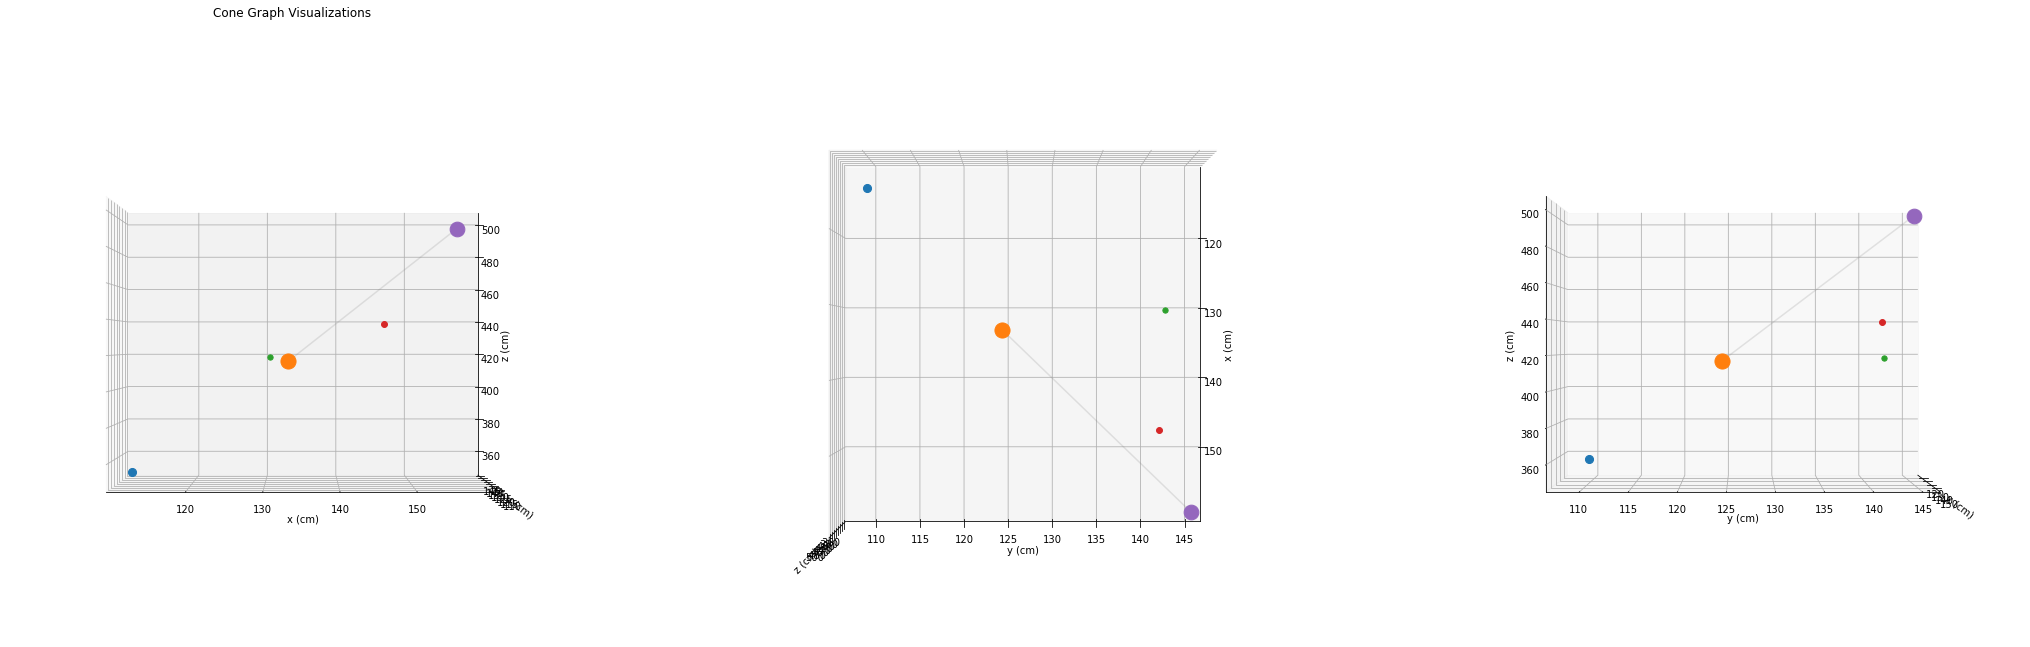

In [86]:
plot_cone_graph(trk_data,angle= .1,eid = 8)

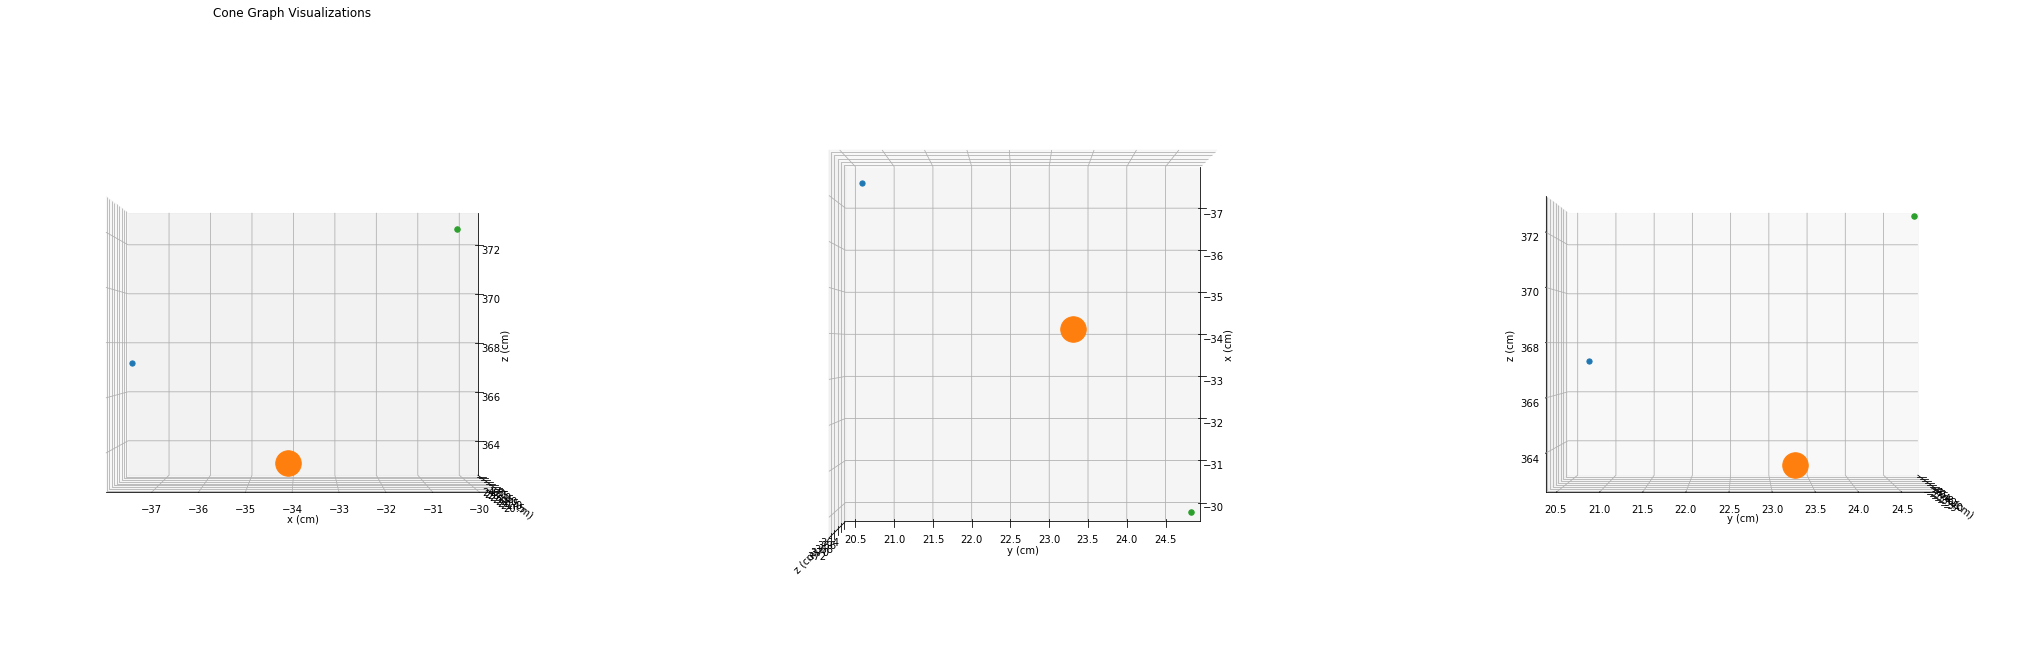

In [87]:
plot_cone_graph(trk_data,angle= .1,eid = 9)

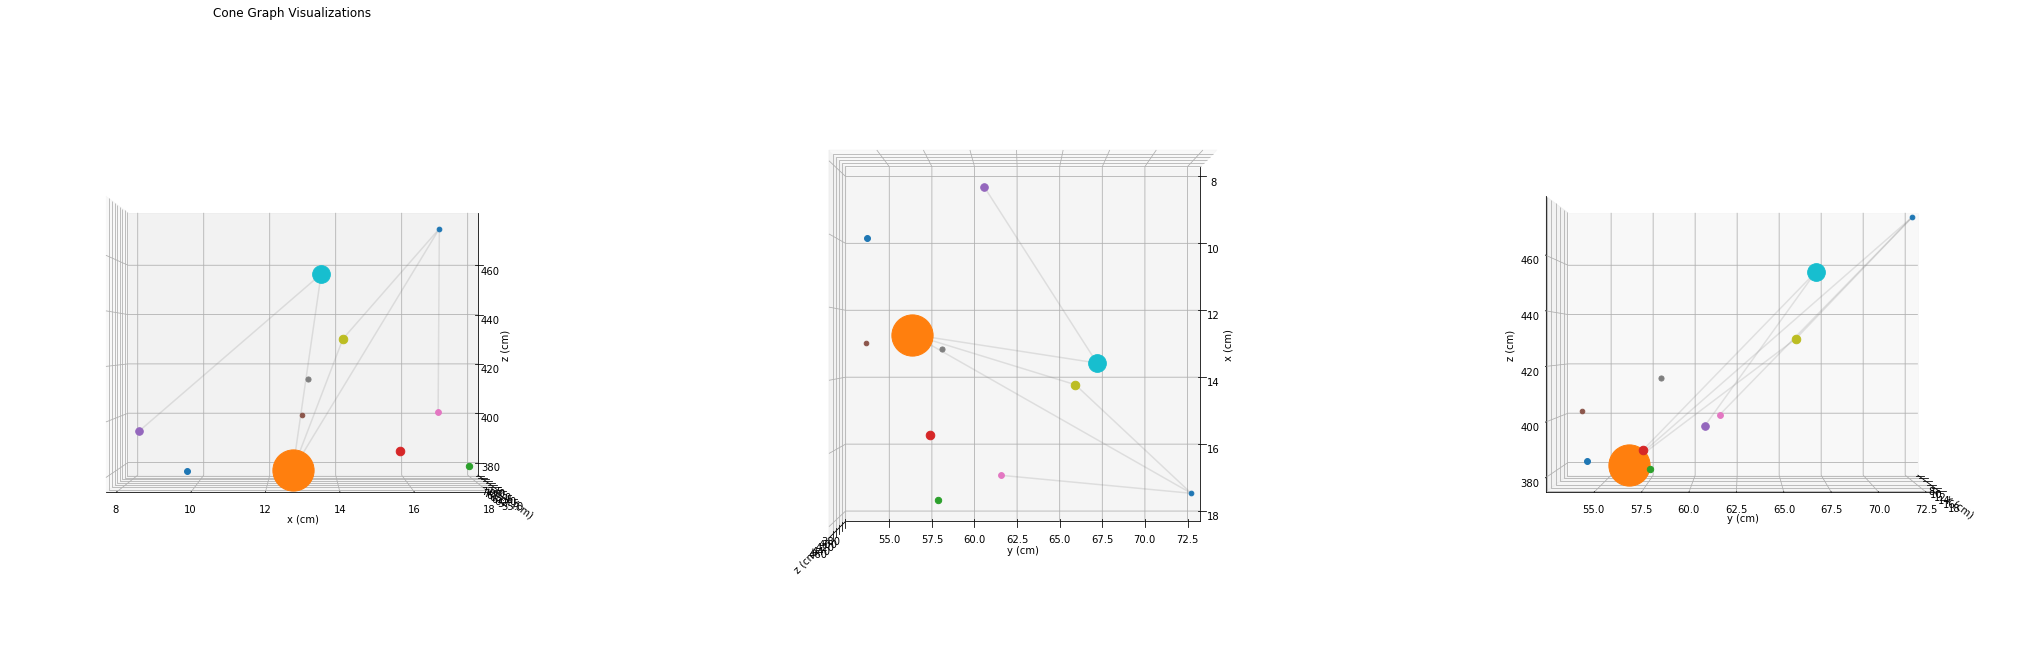

In [88]:
plot_cone_graph(trk_data,angle= .1,eid = 11)

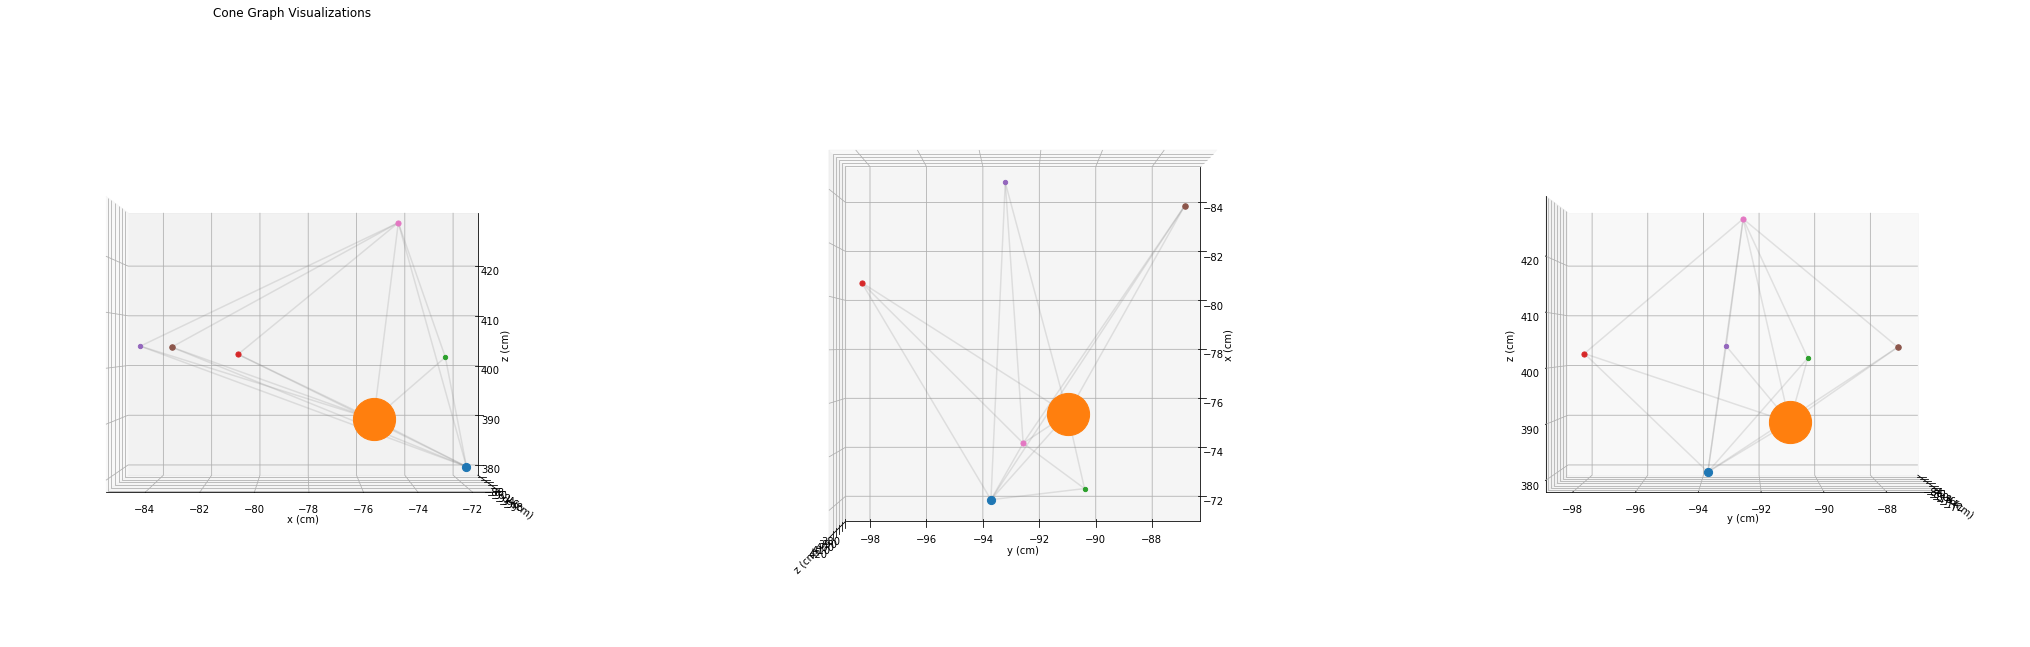

In [97]:
plot_cone_graph(trk_data,angle= .9,eid = 98)

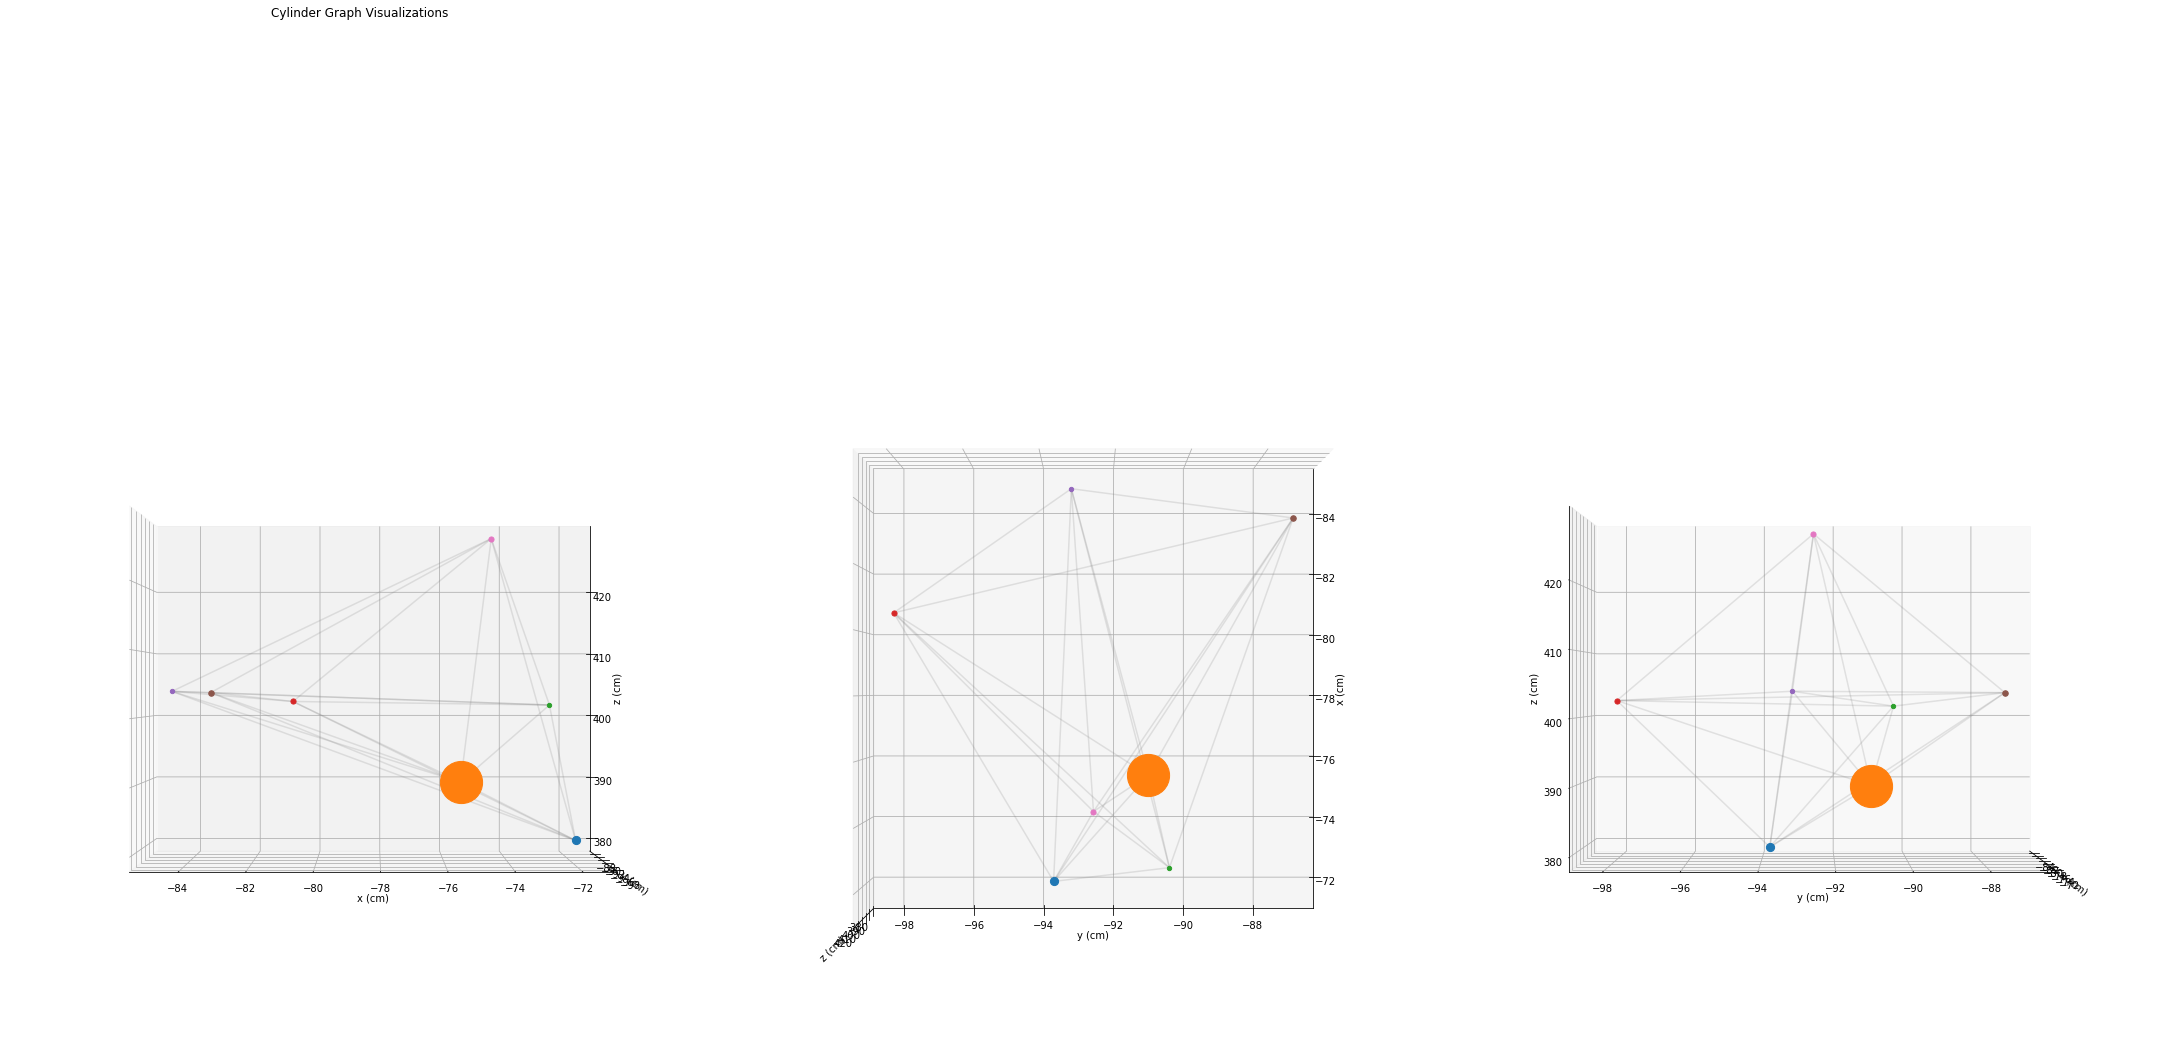

In [96]:
plot_ticl_graph(trk_data,eid = 98)